# Model training

This notebook contains the preparation of the training, the training itself and the analysis of the training results.


In [16]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## Training preparation


In [17]:
# stock_data.csv contains the final dataset including fundamental & scial media trend data
df = pd.read_csv("./../data_works/train_set_pipeline/stock_data.csv", low_memory=False, index_col=0)
df_original = df.copy()
df.head()


,meme_stock,ticker,price_2020-12-01,wsv_2020-12-01,price_2020-12-16,wsv_2020-12-16,price_2021-01-04,wsv_2021-01-04,price_2021-01-20,wsv_2021-01-20,...,volume,fiftyTwoWeekHigh,fiveYearAvgDividendYield,fiftyTwoWeekLow,bid,tradeable,dividendYield,bidSize,dayHigh,fax
0,True,GME,4.277500,86,3.490000,20,4.750000,91,9.342500,597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,AMC,4.430000,1,2.870000,1,2.200000,2,3.290000,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,BBBY,21.290001,0,19.430000,0,17.969999,3,25.110001,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,FIZZ,43.345825,0,38.819767,0,40.557332,0,44.121933,1,...,304714.0,57.65,NaN,38.1,47.31,False,NaN,800.0,53.98,NaN
4,True,BB,8.360000,44,8.350000,4,6.700000,3,13.230000,430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# df[df.ticker.apply(lambda x: not x.isnumeric())]
cols_to_drop = ["city", "state", "country", "financialCurrency", "shortName", "longName", "exchangeTimezoneShortName",
                "isEsgPopulated", "quoteType", "market", "morningStarRiskRating", "fundInceptionDate", "lastFiscalYearEnd", "mostRecentQuarter",
                "legalType", "lastDividendDate", "startDate", "fax", "zip"]
cols_to_encode = ["sector", "industry", "recommendationKey", "exchange", "fundFamily", "tradeable"]
# These have overfitting potential: industry
dummies = pd.get_dummies(df[cols_to_encode])
df = pd.concat([df, dummies], axis=1)


In [19]:
# These feature are potentially needed later on, but not for training
y = df["meme_stock"]
cols_to_drop += ["logo_url", "ticker", "meme_stock"]
df.drop(cols_to_drop+cols_to_encode, axis=1, inplace=True)
# X = df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=41)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


## Hyperparameter tuning


In [20]:
xgb.config_context(verbosity=0)


In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Adjust function from hyperopt package to return integers instead of floats (error in the package)
from hyperopt.pyll import scope
from hyperopt.pyll_utils import validate_label, validate_distribution_range


@validate_label
@validate_distribution_range
def quniform(label, *args, **kwargs):
    return scope.int(scope.hyperopt_param(label, scope.quniform(*args, **kwargs)))


space = {
    'max_depth': hp.quniform("max_depth", 5, 15, 1),
    'learning_rate': hp.uniform("learning_rate", 0.01, 0.5),
    'grow_policy': hp.choice("grow_policy", ["depthwise", "lossguide"]),
    'seed': hp.randint("seed", 100),
    'objective': 'binary:logistic',
}
evallist = [(dtrain, 'train'), (dtest, 'eval')]


In [22]:
def hyperparameter_tuning(space):
    """ Perform hyperparameter tuning with given hyperparameter space. """

    evals_result = {}
    model = xgb.train(space, dtrain, 10, evallist, evals_result=evals_result)

    return {'loss': evals_result["eval"]["logloss"][-1], 'status': STATUS_OK, 'model': model}


In [23]:
# Run Optimization
trials = Trials()
best_params = fmin(fn=hyperparameter_tuning, space=space,
                   algo=tpe.suggest, max_evals=150, trials=trials)
best_params


[0]	train-logloss:0.63337	eval-logloss:0.64599         
[1]	train-logloss:0.59203	eval-logloss:0.60697         
[2]	train-logloss:0.55453	eval-logloss:0.57812         
[3]	train-logloss:0.51970	eval-logloss:0.54792         
[4]	train-logloss:0.49007	eval-logloss:0.52535         
[5]	train-logloss:0.46451	eval-logloss:0.50663         
[6]	train-logloss:0.44223	eval-logloss:0.49117         
[7]	train-logloss:0.42296	eval-logloss:0.47384         
[8]	train-logloss:0.40605	eval-logloss:0.46138         
[9]	train-logloss:0.38559	eval-logloss:0.44647         
[0]	train-logloss:0.49300	eval-logloss:0.54126         
[1]	train-logloss:0.41056	eval-logloss:0.47163                                    
[2]	train-logloss:0.34424	eval-logloss:0.43667                                    
[3]	train-logloss:0.30289	eval-logloss:0.41858                                    
[4]	train-logloss:0.26228	eval-logloss:0.37457                                    
[5]	train-logloss:0.22628	eval-logloss:0.34234      

Pass `evals` as keyword args.



[9]	train-logloss:0.29353	eval-logloss:0.38189                                   
[0]	train-logloss:0.49218	eval-logloss:0.54068                                   
[1]	train-logloss:0.40969	eval-logloss:0.47109                                   
[2]	train-logloss:0.35749	eval-logloss:0.43836                                   
[3]	train-logloss:0.30549	eval-logloss:0.38278                                   
[4]	train-logloss:0.26185	eval-logloss:0.33198                                   
[5]	train-logloss:0.23140	eval-logloss:0.31013                                   
[6]	train-logloss:0.20491	eval-logloss:0.28472                                   
[7]	train-logloss:0.18522	eval-logloss:0.26659                                   
[8]	train-logloss:0.17075	eval-logloss:0.25923                                   
[9]	train-logloss:0.15732	eval-logloss:0.25178                                   
[0]	train-logloss:0.59320	eval-logloss:0.61500                                   
[1]	train-loglos

{'grow_policy': 1,
 'learning_rate': 0.4151780070467866,
 'max_depth': 6.0,
 'seed': 3}

## Model training

Training a final XGB model with best hyperparameters from hyperparameter tuning.


In [24]:
# Set hyperparameters
param = {
    'max_depth': 10,  # Huge number of features require complex model
    'objective': 'binary:logistic',
}


In [25]:
evals_result = {}
best_params["grow_policy"] = ["depthwise", "lossguide"][best_params["grow_policy"]
                                                        ] if isinstance(best_params["grow_policy"], np.int64) else best_params["grow_policy"]
best_params["max_depth"] = int(best_params["max_depth"])
best_params["objective"] = "binary:logistic"
model = xgb.train(best_params, dtrain, 10, evallist, evals_result=evals_result)


[0]	train-logloss:0.48917	eval-logloss:0.53857
[1]	train-logloss:0.40655	eval-logloss:0.46917
[2]	train-logloss:0.35452	eval-logloss:0.43681
[3]	train-logloss:0.30243	eval-logloss:0.38103
[4]	train-logloss:0.25872	eval-logloss:0.33025
[5]	train-logloss:0.22844	eval-logloss:0.30877
[6]	train-logloss:0.20212	eval-logloss:0.28360
[7]	train-logloss:0.18253	eval-logloss:0.26565
[8]	train-logloss:0.16811	eval-logloss:0.25853
[9]	train-logloss:0.15470	eval-logloss:0.25124


## Inference


In [26]:
prediction_results_df = pd.DataFrame(X_test)
prediction_results_df["label"] = list(y_test)
prediction_results_df["prediction"] = model.predict(dtest)
# prediction_results_df_export = prediction_results_df.drop(["label", "prediction"], axis=1)
prediction_results_df.to_csv("../data_works/inference_set.csv", index=False)
prediction_results_df.head(30)


,price_2020-12-01,wsv_2020-12-01,price_2020-12-16,wsv_2020-12-16,price_2021-01-04,wsv_2021-01-04,price_2021-01-20,wsv_2021-01-20,regularMarketPrice,trailingPegRatio,...,recommendationKey_buy,recommendationKey_hold,recommendationKey_strong_buy,recommendationKey_underperform,exchange_NCM,exchange_NMS,exchange_NYQ,tradeable_False,label,prediction
47,7.399025,0,7.339356,0,6.842109,0,9.547129,0,NaN,1.4714,...,0,0,0,0,0,0,0,0,False,0.135202
41,15.806712,0,15.967212,0,16.160985,0,16.463278,0,NaN,NaN,...,0,0,0,0,0,0,0,0,False,0.062785
83,286.329987,0,302.070007,0,294.739990,0,286.470001,0,389.680,NaN,...,1,0,0,0,0,1,0,1,False,0.115777
43,22.230000,0,21.580000,0,20.850000,0,21.250000,0,11.880,NaN,...,0,1,0,0,0,0,1,1,False,0.436550
33,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,...,0,0,0,0,0,0,0,0,False,0.058355
74,23.600381,0,23.332686,0,23.401767,0,23.531296,0,NaN,NaN,...,0,0,0,0,0,0,0,0,False,0.028349
16,11.480000,1,13.490000,3,14.890000,1,17.780001,0,NaN,NaN,...,0,0,0,0,0,0,0,0,True,0.846805
91,56.892667,0,56.567790,0,57.893802,0,56.557560,0,NaN,NaN,...,0,0,0,0,0,0,0,0,False,0.055360
117,355.199188,0,344.383275,0,342.195070,0,330.203072,0,NaN,NaN,...,0,0,0,0,0,0,0,0,False,0.031133
107,0.780000,0,1.040000,0,1.420000,0,3.200000,0,NaN,NaN,...,0,0,0,0,0,0,0,0,False,0.127735


In [27]:
# Prediction analysis
label = prediction_results_df["label"]
prediction = [prediction > 0.7 for prediction in prediction_results_df["prediction"]]
print(f"Accuracy: {accuracy_score(label, prediction)}")
print(f"Precision: {precision_score(label, prediction)}")
print(f"Recall: {recall_score(label, prediction)}")
print(f"F1-Score: {f1_score(label, prediction)}")


Accuracy: 0.92
Precision: 0.6666666666666666
Recall: 1.0
F1-Score: 0.8


In [28]:
# Export data for display on frontend
export_df = pd.DataFrame(index=prediction_results_df.index,
                         data=prediction_results_df[["label", "prediction"]])
export_df["shortName"] = df_original.iloc[export_df.index]["shortName"]
export_df["longName"] = df_original.iloc[export_df.index]["longName"]
export_df["ticker"] = df_original.iloc[export_df.index]["ticker"]
export_df["grossMargins"] = df_original.iloc[export_df.index]["grossMargins"]
export_df["logoURL"] = df_original.iloc[export_df.index]["logo_url"]
export_df["forwardPE"] = df_original.iloc[export_df.index]["forwardPE"]
export_df["MCAP"] = df_original.iloc[export_df.index]["marketCap"]
export_df["WSB_relevance_gain_percent"] = (
    df_original.iloc[export_df.index]["wsv_2021-01-20"] / df_original.iloc[export_df.index]["wsv_2020-12-16"])-1
export_df["WSB_relevance_gain_percent"] = export_df["WSB_relevance_gain_percent"].replace(np.nan, 0)
export_df["WSB_relevance_gain_percent"] = export_df["WSB_relevance_gain_percent"].replace(np.inf, "\u221E")

export_df.head(25)


,label,prediction,shortName,longName,ticker,grossMargins,logoURL,forwardPE,MCAP,WSB_relevance_gain_percent
47,False,0.135202,NaN,NaN,RRC,NaN,NaN,NaN,NaN,0.0
41,False,0.062785,NaN,NaN,TSLX,NaN,NaN,NaN,NaN,0.0
83,False,0.115777,argenx SE,argenx SE,ARGX,-1.44811,https://logo.clearbit.com/argenx.com,-38.851444,2.162794e+10,0.0
43,False,0.436550,"Vivint Smart Home, Inc.","Vivint Smart Home, Inc.",VVNT,0.75753,https://logo.clearbit.com/vivint.com,-18.000000,2.535061e+09,0.0
33,False,0.058355,NaN,NaN,RXST,NaN,NaN,NaN,NaN,0.0
74,False,0.028349,NaN,NaN,COWNL,NaN,NaN,NaN,NaN,0.0
16,True,0.846805,NaN,NaN,CLF,NaN,NaN,NaN,NaN,-1.0
91,False,0.055360,NaN,NaN,MDLZ,NaN,NaN,NaN,NaN,0.0
117,False,0.031133,NaN,NaN,LMT,NaN,NaN,NaN,NaN,0.0
107,False,0.127735,NaN,NaN,MMAT,NaN,NaN,NaN,NaN,0.0


In [29]:
export_df.to_csv("../data_works/inference_set.csv", index=False)


In [30]:
print(list(df_original.columns))


['meme_stock', 'ticker', 'price_2020-12-01', 'wsv_2020-12-01', 'price_2020-12-16', 'wsv_2020-12-16', 'price_2021-01-04', 'wsv_2021-01-04', 'price_2021-01-20', 'wsv_2021-01-20', 'regularMarketPrice', 'logo_url', 'trailingPegRatio', 'zip', 'sector', 'fullTimeEmployees', 'city', 'state', 'country', 'maxAge', 'industry', 'ebitdaMargins', 'profitMargins', 'grossMargins', 'operatingCashflow', 'revenueGrowth', 'operatingMargins', 'ebitda', 'targetLowPrice', 'recommendationKey', 'grossProfits', 'freeCashflow', 'targetMedianPrice', 'currentPrice', 'earningsGrowth', 'currentRatio', 'returnOnAssets', 'numberOfAnalystOpinions', 'targetMeanPrice', 'debtToEquity', 'returnOnEquity', 'targetHighPrice', 'totalCash', 'totalDebt', 'totalRevenue', 'totalCashPerShare', 'financialCurrency', 'revenuePerShare', 'quickRatio', 'recommendationMean', 'exchange', 'shortName', 'longName', 'exchangeTimezoneShortName', 'isEsgPopulated', 'quoteType', 'market', 'enterpriseToRevenue', 'beta3Year', 'enterpriseToEbitda', 

## Model analysis

Analysing the feature importance to better understand dependencies in the data and to condense the dataset down to the relevant features for performant handling in production later on.


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

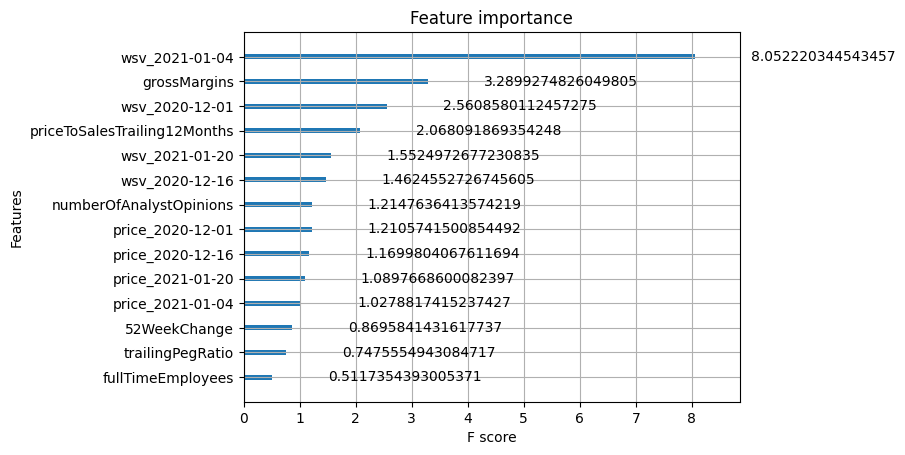

In [31]:
xgb.plot_importance(model, importance_type="gain")


In [32]:
for idx, col in enumerate(list(df.columns)):
    print(f"{idx}: {col}")


0: price_2020-12-01
1: wsv_2020-12-01
2: price_2020-12-16
3: wsv_2020-12-16
4: price_2021-01-04
5: wsv_2021-01-04
6: price_2021-01-20
7: wsv_2021-01-20
8: regularMarketPrice
9: trailingPegRatio
10: fullTimeEmployees
11: maxAge
12: ebitdaMargins
13: profitMargins
14: grossMargins
15: operatingCashflow
16: revenueGrowth
17: operatingMargins
18: ebitda
19: targetLowPrice
20: grossProfits
21: freeCashflow
22: targetMedianPrice
23: currentPrice
24: earningsGrowth
25: currentRatio
26: returnOnAssets
27: numberOfAnalystOpinions
28: targetMeanPrice
29: debtToEquity
30: returnOnEquity
31: targetHighPrice
32: totalCash
33: totalDebt
34: totalRevenue
35: totalCashPerShare
36: revenuePerShare
37: quickRatio
38: recommendationMean
39: enterpriseToRevenue
40: beta3Year
41: enterpriseToEbitda
42: 52WeekChange
43: forwardEps
44: revenueQuarterlyGrowth
45: sharesOutstanding
46: annualReportExpenseRatio
47: totalAssets
48: bookValue
49: sharesShort
50: sharesPercentSharesOut
51: heldPercentInstitutions


In [33]:
# import shap
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580